In [1]:
from google.colab import drive
drive.mount('/content/drive')
dataset_path = '/content/drive/My Drive/Datasets/tic-tac-toe.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install torch_geometric

In [3]:
import pandas as pd
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import numpy as np
import matplotlib.pyplot as plt

## 2. Code Implementation
### 2.1 Load and Preprocess the Dataset

In [4]:
# Load and preprocess dataset
df = pd.read_csv(dataset_path)
df = df.replace({'x': 1, 'o': -1, 'b': 0, 'positive': 1, 'negative': 0})

# Prepare features and labels
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Split into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


### 2.2 Architecture and graph generation

In [16]:
# Create PyTorch Geometric Data objects
def create_graph_data(board_state):
    edge_index = torch.tensor([[0, 1], [1, 2], [3, 4], [4, 5], [6, 7], [7, 8]], dtype=torch.long).t().contiguous()
    x = torch.tensor(board_state, dtype=torch.float).view(-1, 1)
    data = Data(x=x, edge_index=edge_index)
    return data

# Define the GNN model
class TicTacToeGNN(torch.nn.Module):
    def __init__(self):
        super(TicTacToeGNN, self).__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 64)
        self.fc1 = torch.nn.Linear(64, 16)
        self.fc2 = torch.nn.Linear(16, 9)
        self.conv1x1 = torch.nn.Conv1d(16, 32, kernel_size=1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x1 = self.conv1(x, edge_index)
        x1 = x1.relu()
        x2 = self.conv2(x1, edge_index)
        x2 = x2.relu()
        x1_dense = x1.view(1, x1.size(1), x1.size(0))  # Shape: [1, 16, 9]
        x1_adjusted = self.conv1x1(x1_dense)
        x1_adjusted = x1_adjusted.squeeze(0).permute(1, 0)  # Shape: [9, 32]
        # Combine the adjusted features
        x2 = torch.cat([x2, x1_adjusted], dim=1)  # Shape: [9, 64] assuming concatenation

        # Global mean pooling
        x = torch_geometric.nn.global_mean_pool(x2, data.batch)

        # Fully connected layers
        x = self.fc1(x)
        x = x.relu()
        x = self.fc2(x)

        return x

In [17]:
class TicTacToeGNN(torch.nn.Module):
    def __init__(self):
        super(TicTacToeGNN, self).__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 64)
        self.fc1 = torch.nn.Linear(64, 16)
        self.fc2 = torch.nn.Linear(16, 9)
        self.conv1x1 = torch.nn.Conv1d(16, 32, kernel_size=1)
        self.dropout = torch.nn.Dropout(p=0.1)  # Dropout with 50% probability

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x1 = self.conv1(x, edge_index)
        x1 = x1.relu()
        x1 = self.dropout(x1)  # Apply dropout after activation
        x2 = self.conv2(x1, edge_index)
        x2 = x2.relu()
        x2 = self.dropout(x2)  # Apply dropout after activation

        x1_dense = x1.view(1, x1.size(1), x1.size(0))  # Shape: [1, 16, 9]
        x1_adjusted = self.conv1x1(x1_dense)
        x1_adjusted = x1_adjusted.squeeze(0).permute(1, 0)  # Shape: [9, 32]

        # Combine the adjusted features
        x2 = torch.cat([x2, x1_adjusted], dim=1)  # Shape: [9, 64]

        # Global mean pooling
        x = torch_geometric.nn.global_mean_pool(x2, data.batch)

        # Fully connected layers
        x = self.fc1(x)
        x = x.relu()
        x = self.dropout(x)  # Apply dropout before the final layer
        x = self.fc2(x)

        return x


### 2.3 Training and Evaluation

In [20]:
# Training loop with print statements and validation
model = TicTacToeGNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
epochs = 50

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    correct_train = 0
    for index, row in pd.DataFrame(X_train).iterrows():
        board_state = row.values
        target = torch.tensor([y_train[index]], dtype=torch.long)

        data = create_graph_data(board_state)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        # Calculate training accuracy
        pred = out.argmax(dim=1)
        correct_train += pred.eq(target).sum().item()

    train_losses.append(epoch_loss / len(X_train))
    train_accuracies.append(correct_train / len(X_train))

    # Validation
    model.eval()
    val_loss = 0
    correct_val = 0 # Initialize correct_val here
    with torch.no_grad():
        for index, row in pd.DataFrame(X_val).iterrows():
            board_state = row.values
            target = torch.tensor([y_val[index]], dtype=torch.long)

            data = create_graph_data(board_state)
            out = model(data)
            loss = criterion(out, target)
            val_loss += loss.item()

            # Calculate validation accuracy
            pred = out.argmax(dim=1)
            correct_val += pred.eq(target).sum().item()


    val_losses.append(val_loss / len(X_val))
    val_accuracies.append(correct_val / len(X_val))

    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, '
          f'Training Accuracy: {train_accuracies[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.4f}')

Epoch 1/50, Training Loss: 0.8407, Validation Loss: 0.6554, Training Accuracy: 0.5843, Validation Accuracy: 0.6510
Epoch 2/50, Training Loss: 0.6437, Validation Loss: 0.6530, Training Accuracy: 0.6536, Validation Accuracy: 0.6510
Epoch 3/50, Training Loss: 0.6333, Validation Loss: 0.6626, Training Accuracy: 0.6523, Validation Accuracy: 0.6510
Epoch 4/50, Training Loss: 0.6336, Validation Loss: 0.6484, Training Accuracy: 0.6444, Validation Accuracy: 0.6510
Epoch 5/50, Training Loss: 0.6304, Validation Loss: 0.6470, Training Accuracy: 0.6575, Validation Accuracy: 0.6510
Epoch 6/50, Training Loss: 0.6334, Validation Loss: 0.6471, Training Accuracy: 0.6641, Validation Accuracy: 0.6510
Epoch 7/50, Training Loss: 0.6266, Validation Loss: 0.6479, Training Accuracy: 0.6562, Validation Accuracy: 0.6510
Epoch 8/50, Training Loss: 0.6267, Validation Loss: 0.6361, Training Accuracy: 0.6627, Validation Accuracy: 0.6510
Epoch 9/50, Training Loss: 0.6166, Validation Loss: 0.6236, Training Accuracy: 0

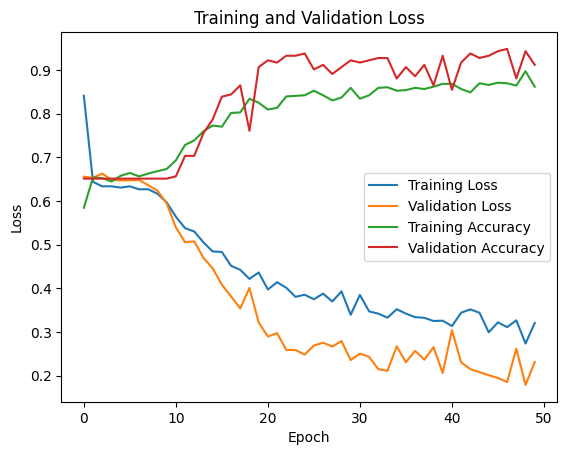

In [21]:
# Plot training and validation losses
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.plot(range(epochs), train_accuracies, label='Training Accuracy')
plt.plot(range(epochs), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [22]:
# Prediction (example)
model.eval()
current_state = np.array([1, -1, 1, 0, 1, -1, 0, 1, -1])  # Current board state
data = create_graph_data(current_state)
with torch.no_grad():
    prediction = model(data)
    move = prediction.argmax().item()
    print(f'Predicted Move: {move}')


Predicted Move: 1


In [23]:
torch.save(model.state_dict(), 'gnn_model.pth')

print("Model saved as gnn_model.pth")

Model saved as gnn_model.pth


#Tic Tac Toe

## Debug code

In [42]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

# Define the GNN model
class GNNModel(torch.nn.Module):
    def __init__(self):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 64)
        self.fc1 = torch.nn.Linear(64, 16)
        self.fc2 = torch.nn.Linear(16, 9)
        self.conv1x1 = torch.nn.Conv1d(16, 32, kernel_size=1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        #print("Initial x shape:", x.shape)

        x1 = self.conv1(x, edge_index)
        #print("After conv1 x1 shape:", x1.shape)

        x1 = x1.relu()
        x2 = self.conv2(x1, edge_index)
        #print("After conv2 x2 shape:", x2.shape)

        x2 = x2.relu()

        # Convert x1 to a dense tensor and adjust for Conv1d
        x1_dense = x1.view(1, x1.size(1), x1.size(0))  # Shape: [1, 16, 9]
        #print("x1_dense shape:", x1_dense.shape)

        # Apply Conv1d
        x1_adjusted = self.conv1x1(x1_dense)
        #print("After conv1x1 x1_adjusted shape:", x1_adjusted.shape)

        # Adjust the shape back to [num_nodes, channels]
        x1_adjusted = x1_adjusted.squeeze(0).permute(1, 0)  # Shape: [9, 32]
        #print("x1_adjusted after permute shape:", x1_adjusted.shape)

        # Combine the adjusted features
        x2 = torch.cat([x2, x1_adjusted], dim=1)  # Shape: [9, 64] assuming concatenation
        #print("Combined x2 shape:", x2.shape)

        # Global mean pooling
        x = torch_geometric.nn.global_mean_pool(x2, data.batch)
        #  print("After pooling x shape:", x.shape)

        # Fully connected layers
        x = self.fc1(x)
        x = x.relu()
        x = self.fc2(x)

        return x

# Define the Tic Tac Toe game
class TicTacToe:
    def __init__(self):
        self.reset_game()
        self.model = self.load_model()  # Load your trained GNN model

    def reset_game(self):
        self.board = np.full((3, 3), '?')
        self.current_player = 'X'
        self.game_over = False
        self.winner = None
        self.winning_cells = []  # Track winning cells
        print("Game has been reset.")

    def load_model(self):
        try:
            # Load the trained GNN model
            model = GNNModel()
            model.load_state_dict(torch.load('gnn_model.pth'))
            model.eval()
            print("Model loaded successfully.")
            return model
        except FileNotFoundError:
            print("Error: The model file 'gnn_model.pth' was not found.")
        except Exception as e:
            print(f"Error loading the model: {e}")

    def suggest_move(self, max_attempts=10):
        if not self.game_over and self.current_player == 'O':  # AI's turn
            attempts = 0
            while attempts < max_attempts:
                try:
                    graph_data = self.create_graph_data(self.board)
                    with torch.no_grad():
                        output = self.model(graph_data)

                        # Convert model output to numpy array
                        output = output.squeeze().numpy()
                        print(f"Model output: {output}")

                        # Mask out invalid moves (already occupied positions)
                        valid_moves_mask = (self.board.flatten() == '?')
                        output[~valid_moves_mask] = -np.inf  # Assign -inf to already taken positions

                        # Find the index of the highest score among valid moves
                        move_index = np.argmax(output)
                        move = divmod(move_index, 3)

                        # Validate the suggested move
                        if self.is_valid_move(move):
                            self.make_move(*move)
                            print(f"AI makes move at position: {move}")
                            return  # Exit after making a valid move
                        else:
                            attempts += 1
                            print(f"Suggested move {move} is invalid or already taken.")
                except Exception as e:
                    print(f"Error during move suggestion: {e}")
                    attempts += 1

            # After exceeding max attempts, notify the user
            print("Max attempts reached. No valid moves found.")

    def is_valid_move(self, move):
        x, y = move
        return 0 <= x < 3 and 0 <= y < 3 and self.board[x, y] == '?'

    def create_graph_data(self, board):
        try:
            board = np.where(board == 'X', 1, np.where(board == 'O', -1, 0))
            node_features = torch.tensor(board, dtype=torch.float).view(-1, 1)

            edge_index = []
            for i in range(3):
                for j in range(3):
                    if i < 2:
                        edge_index.append([i * 3 + j, (i + 1) * 3 + j])
                    if j < 2:
                        edge_index.append([i * 3 + j, i * 3 + (j + 1)])

            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
            print("Graph data created successfully.")
            return Data(x=node_features, edge_index=edge_index)
        except Exception as e:
            print(f"Error creating graph data: {e}")
            raise

    def make_move(self, x, y):
        if not self.game_over and self.board[x, y] == '?':
            self.board[x, y] = self.current_player
            print(f"Player {self.current_player} makes a move at ({x}, {y})")
            if self.check_winner():
                self.game_over = True
                self.winner = self.current_player
                print(f"Player {self.winner} wins!")
            elif np.all(self.board != '?'):
                self.game_over = True
                self.winner = 'Draw'
                print("The game is a draw!")
            else:
                self.current_player = 'O' if self.current_player == 'X' else 'X'
                self.suggest_move()
            self.update_ui()

    def check_winner(self):
        for i in range(3):
            if np.all(self.board[i, :] == self.current_player) or np.all(self.board[:, i] == self.current_player):
                self.winning_cells = [(i, j) for j in range(3)] if np.all(self.board[i, :] == self.current_player) else [(j, i) for j in range(3)]
                return True
        if self.board[0, 0] == self.current_player and self.board[1, 1] == self.current_player and self.board[2, 2] == self.current_player:
            self.winning_cells = [(i, i) for i in range(3)]
            return True
        if self.board[0, 2] == self.current_player and self.board[1, 1] == self.current_player and self.board[2, 0] == self.current_player:
            self.winning_cells = [(i, 2 - i) for i in range(3)]
            return True
        return False

    def update_ui(self):
        for i in range(3):
            for j in range(3):
                button = self.buttons[i][j]
                button.description = self.board[i, j]
                button.disabled = self.board[i, j] != '?'
                # Reset button color
                button.style.button_color = 'black'

        if self.game_over:
            if self.winner == 'Draw':
                result_text = 'The game is a draw!'
            else:
                result_text = f'Player {self.winner} wins!'
                # Highlight winning cells
                for (x, y) in self.winning_cells:
                    button = self.buttons[x][y]
                    button.style.button_color = 'darkblue'  # Set button color to green

            self.result_label.value = result_text
            print("UI updated.")

    def create_ui(self):
        self.buttons = [[None for _ in range(3)] for _ in range(3)]
        button_grid = widgets.GridBox(
            children=[widgets.Button(description='?', layout=widgets.Layout(width='100px', height='100px')) for _ in range(9)],
            layout=widgets.Layout(grid_template_columns='repeat(3, 100px)')
        )
        self.result_label = widgets.Label(value='')
        self.ui = widgets.VBox([button_grid, self.result_label])
        for i in range(3):
            for j in range(3):
                button = button_grid.children[i * 3 + j]
                button.on_click(lambda btn, x=i, y=j: self.make_move(x, y))
                self.buttons[i][j] = button
        self.update_ui()  # Update UI after creating it
        print("UI created.")
        return self.ui

# Create and display the game UI
game = TicTacToe()
display(game.create_ui())


Game has been reset.
Model loaded successfully.
UI created.


Player X makes a move at (1, 2)
Graph data created successfully.
Model output: [ -1.4781239   1.9224527 -20.812729  -21.174875  -20.848154  -20.945066
 -20.410206  -20.560534  -20.44532  ]
Player O makes a move at (0, 1)
AI makes move at position: (0, 1)


## Execution code

In [46]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import random

# Define the GNN model
class GNNModel(torch.nn.Module):
    def __init__(self):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 64)
        self.fc1 = torch.nn.Linear(64, 16)
        self.fc2 = torch.nn.Linear(16, 9)
        self.conv1x1 = torch.nn.Conv1d(16, 32, kernel_size=1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x1 = self.conv1(x, edge_index)
        x1 = x1.relu()
        x2 = self.conv2(x1, edge_index)
        x2 = x2.relu()

        # Convert x1 to a dense tensor and adjust for Conv1d
        x1_dense = x1.view(1, x1.size(1), x1.size(0))  # Shape: [1, 16, 9]

        # Apply Conv1d
        x1_adjusted = self.conv1x1(x1_dense)

        # Adjust the shape back to [num_nodes, channels]
        x1_adjusted = x1_adjusted.squeeze(0).permute(1, 0)  # Shape: [9, 32]

        # Combine the adjusted features
        x2 = torch.cat([x2, x1_adjusted], dim=1)  # Shape: [9, 64] assuming concatenation

        # Global mean pooling
        x = torch_geometric.nn.global_mean_pool(x2, data.batch)

        # Fully connected layers
        x = self.fc1(x)
        x = x.relu()
        x = self.fc2(x)

        return x

# Define the Tic Tac Toe game
class TicTacToe:
    def __init__(self):
        self.reset_game()
        self.model = self.load_model()  # Load your trained GNN model

    def reset_game(self):
        self.board = np.full((3, 3), '?')
        self.current_player = 'X'
        self.game_over = False
        self.winner = None
        self.winning_cells = []  # Track winning cells
        print("Game has been reset.")

    def load_model(self):
        try:
            # Load the trained GNN model
            model = GNNModel()
            model.load_state_dict(torch.load('gnn_model.pth'))
            model.eval()
            print("Model loaded successfully.")
            return model
        except FileNotFoundError:
            print("Error: The model file 'gnn_model.pth' was not found.")
        except Exception as e:
            print(f"Error loading the model: {e}")

    def suggest_move(self, max_attempts=10):
        if not self.game_over and self.current_player == 'O':  # AI's turn
            attempts = 0
            while attempts < max_attempts:
                try:
                    graph_data = self.create_graph_data(self.board)
                    with torch.no_grad():
                        output = self.model(graph_data)

                        # Convert model output to numpy array
                        output = output.squeeze().numpy()
                        print(f"Model output: {output}")

                        # Mask out invalid moves (already occupied positions)
                        valid_moves_mask = (self.board.flatten() == '?')
                        output[~valid_moves_mask] = -np.inf  # Assign -inf to already taken positions

                        # Find the index of the highest score among valid moves
                        move_index = np.argmax(output)
                        move = divmod(move_index, 3)

                        # Validate the suggested move
                        if self.is_valid_move(move):
                            self.make_move(*move)
                            print(f"AI makes move at position: {move}")
                            return  # Exit after making a valid move
                        else:
                            attempts += 1
                            print(f"Suggested move {move} is invalid or already taken.")
                except Exception as e:
                    print(f"Error during move suggestion: {e}")
                    attempts += 1

            # After exceeding max attempts, notify the user
            print("Max attempts reached. No valid moves found.")

    def is_valid_move(self, move):
        x, y = move
        return 0 <= x < 3 and 0 <= y < 3 and self.board[x, y] == '?'

    def create_graph_data(self, board):
        try:
            board = np.where(board == 'X', 1, np.where(board == 'O', -1, 0))
            node_features = torch.tensor(board, dtype=torch.float).view(-1, 1)

            edge_index = []
            for i in range(3):
                for j in range(3):
                    if i < 2:
                        edge_index.append([i * 3 + j, (i + 1) * 3 + j])
                    if j < 2:
                        edge_index.append([i * 3 + j, i * 3 + (j + 1)])

            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
            print("Graph data created successfully.")
            return Data(x=node_features, edge_index=edge_index)
        except Exception as e:
            print(f"Error creating graph data: {e}")
            raise

    def select_initial_move(self):
        """
        Selects a random initial move for the AI from the available grid positions.

        Returns:
        - tuple: The chosen grid position (row, col).
        """
        available_moves = [(row, col) for row in range(3) for col in range(3) if self.board[row, col] == '?']
        return random.choice(available_moves)

    def make_move(self, x, y):
        if not self.game_over and self.board[x, y] == '?':
            self.board[x, y] = self.current_player
            print(f"Player {self.current_player} makes a move at ({x}, {y})")

            if self.check_winner():
                self.game_over = True
                self.winner = self.current_player
                print(f"Player {self.winner} wins!")
            elif np.all(self.board != '?'):
                self.game_over = True
                self.winner = 'Draw'
                print("The game is a draw!")
            else:
                self.current_player = 'O' if self.current_player == 'X' else 'X'
                if self.current_player == 'O':  # AI's turn
                    if np.sum(self.board == 'X') == 1:  # Check if this is the AI's first move
                        x, y = self.select_initial_move()  # Select a random initial move
                        self.board[x, y] = 'O'
                        print(f"AI makes a move at ({x}, {y})")
                    else:
                        self.suggest_move()  # AI makes a subsequent move based on existing logic
                else:
                    self.suggest_move()

            self.update_ui()

    def check_winner(self):
        for i in range(3):
            if np.all(self.board[i, :] == self.current_player) or np.all(self.board[:, i] == self.current_player):
                self.winning_cells = [(i, j) for j in range(3)] if np.all(self.board[i, :] == self.current_player) else [(j, i) for j in range(3)]
                return True
        if self.board[0, 0] == self.current_player and self.board[1, 1] == self.current_player and self.board[2, 2] == self.current_player:
            self.winning_cells = [(i, i) for i in range(3)]
            return True
        if self.board[0, 2] == self.current_player and self.board[1, 1] == self.current_player and self.board[2, 0] == self.current_player:
            self.winning_cells = [(i, 2 - i) for i in range(3)]
            return True
        return False

    def update_ui(self):
        for i in range(3):
            for j in range(3):
                button = self.buttons[i][j]
                button.description = self.board[i, j]
                button.disabled = self.board[i, j] != '?'
                # Reset button color
                button.style.button_color = 'black'

        if self.game_over:
            if self.winner == 'Draw':
                result_text = 'The game is a draw!'
            else:
                result_text = f'Player {self.winner} wins!'
                # Highlight winning cells
                for (x, y) in self.winning_cells:
                    button = self.buttons[x][y]
                    button.style.button_color = 'darkblue'  # Set button color to green

            self.result_label.value = result_text
            print("UI updated.")

    def create_ui(self):
        self.buttons = [[None for _ in range(3)] for _ in range(3)]
        button_grid = widgets.GridBox(
            children=[widgets.Button(description='?', layout=widgets.Layout(width='100px', height='100px')) for _ in range(9)],
            layout=widgets.Layout(grid_template_columns='repeat(3, 100px)')
        )
        self.result_label = widgets.Label(value='')
        self.ui = widgets.VBox([button_grid, self.result_label])
        for i in range(3):
            for j in range(3):
                button = button_grid.children[i * 3 + j]
                button.on_click(lambda btn, x=i, y=j: self.make_move(x, y))
                self.buttons[i][j] = button
        self.update_ui()  # Update UI after creating it
        print("UI created.")
        return self.ui

# Create and display the game UI
game = TicTacToe()
display(game.create_ui())


Game has been reset.
Model loaded successfully.
UI created.


Player X makes a move at (1, 0)
AI makes a move at (0, 0)
Player O makes a move at (2, 0)
Player X makes a move at (2, 1)
Graph data created successfully.
Model output: [  0.562423    -0.24964792 -11.169189   -11.606956   -11.030119
 -11.221642   -11.027854   -11.325856   -10.903578  ]
Player O makes a move at (0, 1)
AI makes move at position: (0, 1)
Player X makes a move at (1, 2)
Graph data created successfully.
Model output: [  1.4115385   -0.87139183 -13.610288   -13.910264   -13.238232
 -13.484078   -13.469977   -13.8601465  -13.27338   ]
Player O makes a move at (1, 1)
AI makes move at position: (1, 1)
Player X makes a move at (0, 2)
Graph data created successfully.
Model output: [ -0.39347947   0.5104623  -11.046188   -11.575826   -11.045471
 -11.250231   -10.822266   -11.0597925  -10.630701  ]
Player O makes a move at (2, 2)
Player O wins!
UI updated.
AI makes move at position: (2, 2)
UI updated.


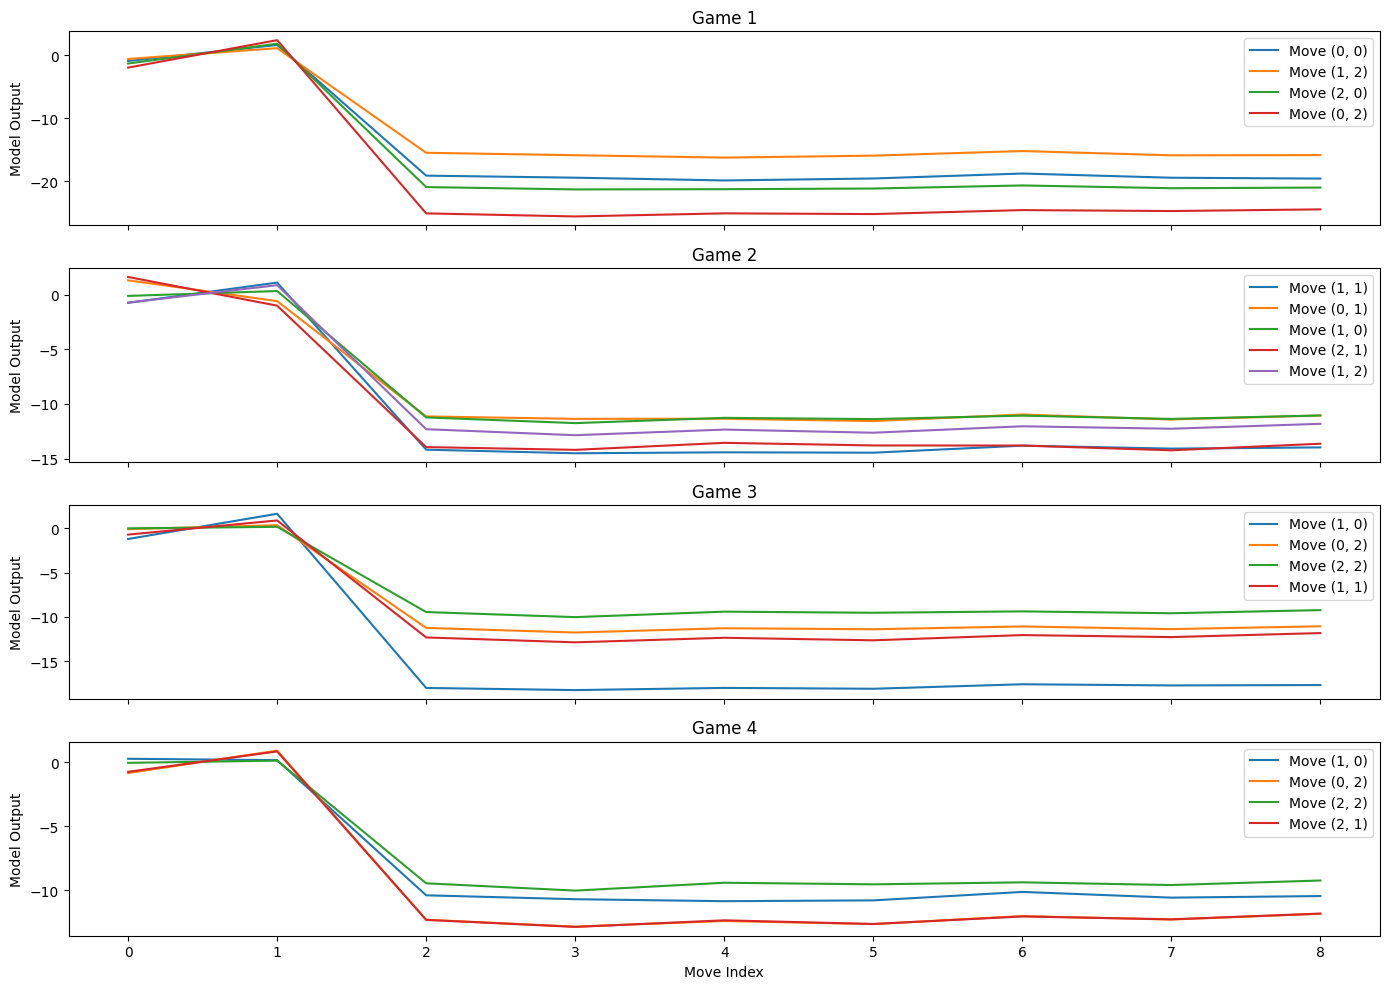

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Data
data = {
    "Game 1": {
        "Move (0, 0)": [-0.906861, 1.6395006, -19.101936, -19.427176, -19.865484, -19.554773, -18.76664, -19.433413, -19.57008],
        "Move (1, 2)": [-0.58579683, 1.1274629, -15.47419, -15.862622, -16.237776, -15.929423, -15.198868, -15.8756, -15.841072],
        "Move (2, 0)": [-1.3097003, 1.8378669, -20.916582, -21.288681, -21.251703, -21.147968, -20.658566, -21.098045, -20.997734],
        "Move (0, 2)": [-1.9573162, 2.400592, -25.089827, -25.579283, -25.086197, -25.201704, -24.570038, -24.720627, -24.454645]
    },
    "Game 2": {
        "Move (1, 1)": [-0.753412, 1.0956471, -14.179107, -14.506994, -14.419573, -14.453978, -13.810868, -14.08023, -13.970917],
        "Move (0, 1)": [1.3037555, -0.5973441, -11.140506, -11.361657, -11.350048, -11.564714, -10.962778, -11.418259, -11.052259],
        "Move (1, 0)": [-0.12297363, 0.3236515, -11.228957, -11.749885, -11.268734, -11.38296, -11.067655, -11.366637, -11.051983],
        "Move (2, 1)": [1.6099117, -1.0129122, -13.942411, -14.194681, -13.554123, -13.791562, -13.8008995, -14.235701, -13.634502],
        "Move (1, 2)": [-0.73474544, 0.8590791, -12.305415, -12.856056, -12.341284, -12.6274, -12.03998, -12.26409, -11.813797]
    },
    "Game 3": {
        "Move (1, 0)": [-1.2284417, 1.6073706, -17.988152, -18.227716, -17.981886, -18.078232, -17.57238, -17.703539, -17.659775],
        "Move (0, 2)": [-0.12297363, 0.3236515, -11.228957, -11.749885, -11.268734, -11.38296, -11.067655, -11.366637, -11.051983],
        "Move (2, 2)": [-0.03220703, 0.14022535, -9.448123, -10.018313, -9.404374, -9.528239, -9.373032, -9.582803, -9.230366],
        "Move (1, 1)": [-0.73474544, 0.8590791, -12.305415, -12.856056, -12.341284, -12.6274, -12.03998, -12.26409, -11.813797]
    },
    "Game 4": {
        "Move (1, 0)": [0.2850649, 0.1775552, -10.387311, -10.690881, -10.84549, -10.78235, -10.12121, -10.568153, -10.445135],
        "Move (0, 2)": [-0.83203083, 0.92427564, -12.297713, -12.834428, -12.396162, -12.636375, -12.0077715, -12.280036, -11.833147],
        "Move (2, 2)": [-0.03220703, 0.14022535, -9.448123, -10.018313, -9.404374, -9.528239, -9.373032, -9.582803, -9.230366],
        "Move (2, 1)": [-0.73474544, 0.8590791, -12.305415, -12.856056, -12.341284, -12.6274, -12.03998, -12.26409, -11.813797]
    }
}

# Plotting
fig, axs = plt.subplots(len(data), figsize=(14, 10), sharex=True)

for i, (game, moves) in enumerate(data.items()):
    for move, values in moves.items():
        axs[i].plot(values, label=f'{move}')
    axs[i].set_title(game)
    axs[i].set_ylabel('Model Output')
    axs[i].legend()

axs[-1].set_xlabel('Move Index')
plt.tight_layout()
plt.show()
